In [ ]:
# GDrive mount (required only if being run on GDrive)
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# importing dependencies

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
##### PLEASE SET THESE CAREFULLY refer :instructions.txt

INPUT_DIR = "/gdrive/Shareddrives/DLNN_ProjC1/output/new_data_augmentation"
OUTPUT_DIR= "/gdrive/Shareddrives/DLNN_ProjC1/output/new_data_sampling"
#####


# some constants
ATTRIBUTE_NAMES = ["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z", "CLASS"]
X_NAMES = ["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"]
WINDOW_SIZE = 160 #4s

In [ ]:
# some functions to make plotting data easy

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))

        val = int(val / 1000)
        return '{p:.2f}%  ({v:d}K)'.format(p=pct,v=val)
    return my_autopct

def distribution_pie(dataset, title):
  aug_0 = np.where(dataset==0)[0].shape[0]
  aug_1 = np.where(dataset==1)[0].shape[0]
  aug_2 = np.where(dataset==2)[0].shape[0]
  aug_3 = np.where(dataset==3)[0].shape[0]

  print(aug_0, aug_1, aug_2, aug_3)
  plt.figure(figsize=(6, 6))
  plt.title(title)
  plt.pie([aug_0, aug_1, aug_2, aug_3], labels = ["zero", "one", "two", "three"],
          labeldistance= True, autopct=make_autopct([aug_0, aug_1, aug_2, aug_3]), explode = (0.1, 0.1, 0.1, 0.1))
  plt.legend()

  plt.show()

In [ ]:
# Loading the data from the file

sessions = {}
counts_of_classes = pd.DataFrame([], columns = ["filename", "zero", "one", "two", "three"])

input_files =  sorted(os.listdir(INPUT_DIR))

for input_file in input_files:
  if ".csv" in input_file:
    print("reading:", input_file, end = "\t")
    sessions[input_file] = pd.read_csv(os.path.join(INPUT_DIR, input_file))

    value_counts = sessions[input_file].CLASS.value_counts()
    for col in range(0, 4):
      if col not in value_counts.keys():
        value_counts[float(col)] = 0

        print(col, "appended")
        print(value_counts.keys())


    
    counts_of_classes = counts_of_classes.append([{"filename": input_file,
                                                      "zero": value_counts[0],                                                      
                                                      "one": value_counts[1],
                                                      "two": value_counts[2],
                                                      "three": value_counts[3]}], 
                                                      ignore_index=True)
    print("shape:", sessions[input_file].shape)

print("data_set_loaded")

reading: subject_001_01_x_sync_fast.csv	shape: (34101, 7)
reading: subject_001_01_x_sync_m_fast.csv	shape: (35995, 7)
reading: subject_001_01_x_sync_m_slow.csv	shape: (39784, 7)
reading: subject_001_01_x_sync_same.csv	shape: (37890, 7)
reading: subject_001_01_x_sync_slow.csv	shape: (41679, 7)
reading: subject_001_02_x_sync_fast.csv	shape: (63154, 7)
reading: subject_001_02_x_sync_m_fast.csv	shape: (66663, 7)
reading: subject_001_02_x_sync_m_slow.csv	shape: (73680, 7)
reading: subject_001_02_x_sync_same.csv	shape: (70172, 7)
reading: subject_001_02_x_sync_slow.csv	shape: (77189, 7)
reading: subject_001_03_x_sync_fast.csv	shape: (38831, 7)
reading: subject_001_03_x_sync_m_fast.csv	shape: (40988, 7)
reading: subject_001_03_x_sync_m_slow.csv	shape: (45303, 7)
reading: subject_001_03_x_sync_same.csv	shape: (43146, 7)
reading: subject_001_03_x_sync_slow.csv	shape: (47460, 7)
reading: subject_001_04_x_sync_fast.csv	shape: (49460, 7)
reading: subject_001_04_x_sync_m_fast.csv	shape: (52208, 7)


In [ ]:
# checking representation of classes in the loaded data-set
print(counts_of_classes.zero.sum(), counts_of_classes.one.sum(),
counts_of_classes.two.sum(), counts_of_classes.three.sum())

5033457 277733 365405 1031579


In [ ]:
# sample the train_set

random.seed("DLNN-G33")



 
aug_set = np.zeros(shape = (1, WINDOW_SIZE, 7), dtype=np.float64)

# dropping 70% of the frames that only have 0s
DROPPING_PROBABILITY_FOR_0 = 0.70

# atleast 10% of rows should be of a particular class for us to associate that frame with that class
MINIMIUM_REPRESENTATION_FOR_PRESENCE = 10

# when adding copies of the same frame, we add a random noise (upto 15%) to each frame 
NOISE_PERCENT = 15

# this is the resistance offered to the sliding window if a particular class is encountered
RESISTANCE_WINDOW_FACTOR_FOR_1 = 3.5
RESISTANCE_WINDOW_FACTOR_FOR_2 = 3.6
RESISTANCE_WINDOW_FACTOR_FOR_3 = 1.5
        

# over-sampling     
for input_file in sessions.keys():
  temp_df = sessions[input_file]
  total_samples = temp_df.shape[0]
  pointer = 0
  print("Processing: ",input_file)
  print("Sample in this file:",  total_samples)
  while(pointer + WINDOW_SIZE < total_samples):
    
    candidate_sequence = temp_df.iloc[pointer: pointer+WINDOW_SIZE]
    
    value_counts = candidate_sequence.CLASS.value_counts()
    classes_present = value_counts.keys()



    candidate_sequence = np.array(candidate_sequence)

    candidate_sequence = np.expand_dims(candidate_sequence, 0)
    if 1 in classes_present:
      if value_counts[1] > WINDOW_SIZE//MINIMIUM_REPRESENTATION_FOR_PRESENCE:
        aug_set = np.append(aug_set, candidate_sequence,  axis=0)
        noise = 1 + (np.random.rand(candidate_sequence.shape[0], WINDOW_SIZE, 6) - 0.5) * (NOISE_PERCENT*2 / 100)
        candidate_sequence[..., :6] = np.multiply(candidate_sequence[..., :6], noise)
        aug_set = np.append(aug_set, candidate_sequence,  axis=0)
        
      pointer += int(WINDOW_SIZE // RESISTANCE_WINDOW_FACTOR_FOR_1)
      

    elif 2 in classes_present:
      if value_counts[2] > WINDOW_SIZE//MINIMIUM_REPRESENTATION_FOR_PRESENCE:
        aug_set = np.append(aug_set, candidate_sequence, axis=0)
        noise = 1 + (np.random.rand(candidate_sequence.shape[0], WINDOW_SIZE, 6) - 0.5) * (NOISE_PERCENT*2 / 100)
        candidate_sequence[..., :6] = np.multiply(candidate_sequence[..., :6], noise)        
        aug_set = np.append(aug_set, candidate_sequence, axis=0)
        
      pointer += int(WINDOW_SIZE // RESISTANCE_WINDOW_FACTOR_FOR_2)

    elif 3 in classes_present:
      if value_counts[3] > WINDOW_SIZE//MINIMIUM_REPRESENTATION_FOR_PRESENCE:
        aug_set = np.append(aug_set, candidate_sequence, axis=0)
        noise = 1 + (np.random.rand(candidate_sequence.shape[0], WINDOW_SIZE, 6) - 0.5) * (NOISE_PERCENT*2 / 100)
        candidate_sequence[..., :6] = np.multiply(candidate_sequence[..., :6], noise)
        aug_set = np.append(aug_set, candidate_sequence, axis=0)
        
      pointer += int(WINDOW_SIZE // RESISTANCE_WINDOW_FACTOR_FOR_3)

    else:
      # drop with dropping frequency
      if random.uniform(0, 1) < DROPPING_PROBABILITY_FOR_0:
        # print("dropped")
        pointer +=WINDOW_SIZE;
        continue
      else:
        # print("not_dropped")
        aug_set = np.append(aug_set, candidate_sequence, axis=0)
        pointer +=WINDOW_SIZE;
        continue
  print("DONE")
  
  
aug_set = aug_set[1:]

Processing:  subject_001_01_x_sync_fast.csv
Sample in this file: 34101
DONE
Processing:  subject_001_01_x_sync_m_fast.csv
Sample in this file: 35995
DONE
Processing:  subject_001_01_x_sync_m_slow.csv
Sample in this file: 39784
DONE
Processing:  subject_001_01_x_sync_same.csv
Sample in this file: 37890
DONE
Processing:  subject_001_01_x_sync_slow.csv
Sample in this file: 41679
DONE
Processing:  subject_001_02_x_sync_fast.csv
Sample in this file: 63154
DONE
Processing:  subject_001_02_x_sync_m_fast.csv
Sample in this file: 66663
DONE
Processing:  subject_001_02_x_sync_m_slow.csv
Sample in this file: 73680
DONE
Processing:  subject_001_02_x_sync_same.csv
Sample in this file: 70172
DONE
Processing:  subject_001_02_x_sync_slow.csv
Sample in this file: 77189
DONE
Processing:  subject_001_03_x_sync_fast.csv
Sample in this file: 38831
DONE
Processing:  subject_001_03_x_sync_m_fast.csv
Sample in this file: 40988
DONE
Processing:  subject_001_03_x_sync_m_slow.csv
Sample in this file: 45303
DONE


(58840, 160, 7)
(array([0., 1., 2., 3.]), array([2709482, 1877624, 1954392, 2872902]))
2709482 1877624 1954392 2872902


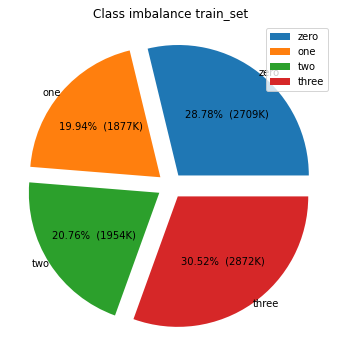

In [ ]:
# checking class repreentation in the final dataset

print(aug_set.shape)
print(np.unique(aug_set[:, :, -1].flatten(), return_counts=True))

temp = aug_set[:, :, -1].flatten()
distribution_pie(temp, "Class imbalance train_set")

In [ ]:
# saving dataset
np.save(os.path.join(OUTPUT_DIR, "dataset.npy"), aug_set)

In [ ]:


x_mean = np.mean(np.mean((aug_set[:, :, :6]), axis = 0), axis = 0)
x_std = np.mean(np.std((aug_set[:, :, :6]), axis = 0), axis = 0)
x_min = np.min(np.min((aug_set[:, :, :6]), axis = 0), axis = 0)
x_max = np.max(np.max((aug_set[:, :, :6]), axis = 0), axis = 0)

In [ ]:
# saving normalization-information in file

np.save(os.path.join(OUTPUT_DIR, "x_mean.npy"), x_mean)
np.save(os.path.join(OUTPUT_DIR, "x_stddev.npy"), x_std)
np.save(os.path.join(OUTPUT_DIR, "x_min.npy"), x_min)
np.save(os.path.join(OUTPUT_DIR, "x_max.npy"), x_max)